## EDA and Data Cleaning

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import gzip as gz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from zipfile import ZipFile
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, f1_score, plot_roc_curve, plot_confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from statsmodels.api import qqplot
from scipy import stats

In [2]:
# Load and explore dataset
nba = 'NBAInjuries.zip'
with ZipFile(nba, 'r') as zip:
    zip.extractall('nba_unzipped')
    
df = pd.read_csv('nba_unzipped/injuries_2010-2020.csv')
df

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)
...,...,...,...,...,...
27100,2020-09-30,Lakers,Dion Waiters,NaN,activated from IL
27101,2020-10-02,Heat,NaN,Bam Adebayo,strained neck (DTD)
27102,2020-10-02,Heat,NaN,Goran Dragic,placed on IL with torn plantar fascia in left ...
27103,2020-10-02,Heat,Chris Silva,NaN,activated from IL


In [3]:
# Drop Acquired column, null values, and rename Relinquished to Name
df.drop(['Acquired'], axis=1, inplace=True)
df.dropna(inplace=True)
df.rename(columns={'Relinquished':'Name'}, inplace=True)
pd.set_option('display.max_colwidth', None)
df.head()

,Date,Team,Name,Notes
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger (out indefinitely)
1,2010-10-06,Pistons,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot (out indefinitely)
3,2010-10-08,Blazers,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,Troy Murphy,strained lower back (out indefinitely)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17558 entries, 0 to 27102
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    17558 non-null  object
 1   Team    17558 non-null  object
 2   Name    17558 non-null  object
 3   Notes   17558 non-null  object
dtypes: object(4)
memory usage: 685.9+ KB


In [5]:
# Create series of Notes column
s1 = df.Notes

In [6]:
# Identified injuries that were seaon ending
out_for_season = s1.str.contains('out for season', case=False)
out_for_season.value_counts()

False    16433
True      1125
Name: Notes, dtype: int64

In [7]:
# Binary label out_of_season as target
df = df.assign(out_for_season=pd.Series(out_for_season).values)
df = df*1

# Dataset of injuries that resulted in player being 'out for season'
ofs = df[(df['Notes'].str.contains('out for season', case=False))]
ofs.head()

,Date,Team,Name,Notes,out_for_season
8,2010-10-12,Bucks,Darington Hobson,surgery on left hip (out for season),1
17,2010-10-26,Blazers,Greg Oden,placed on IL with left knee injury (out for season),1
75,2010-10-27,Pistons,Jonas Jerebko,placed on IL recovering from surgery to repair torn right Achilles tendon (out for season),1
76,2010-10-27,Pistons,Terrico White,placed on IL recovering from surgery on right foot to repair broken fifth metatarsal (out for season),1
175,2010-11-04,Blazers,Elliot Williams,"dislocated patella in right knee (surgery, out for season)",1


In [8]:
# Split injury data by season
ofs_10 = ofs[(ofs['Date'] < '2011-07-01')]
ofs_11 = ofs[(ofs['Date'].between('2011-07-01','2012-07-01'))]
ofs_12 = ofs[(ofs['Date'].between('2012-07-01','2013-07-01'))]
ofs_13 = ofs[(ofs['Date'].between('2013-07-01','2014-07-01'))]
ofs_14 = ofs[(ofs['Date'].between('2014-07-01','2015-07-01'))]
ofs_15 = ofs[(ofs['Date'].between('2015-07-01','2016-07-01'))]
ofs_16 = ofs[(ofs['Date'].between('2016-07-01','2017-07-01'))]
ofs_17 = ofs[(ofs['Date'].between('2017-07-01','2018-07-01'))]
ofs_18 = ofs[(ofs['Date'].between('2018-07-01','2019-07-01'))]

Multiple entries for same player and injury are noted. The duplicates need to be removed.

In [9]:
# Function to drop duplicates
def DropDuplicates(dataset):
    return dataset.drop_duplicates(subset=['Name'], inplace=True)

# Make list of season datasets
list_ofs = [ofs_10, ofs_11, ofs_12, ofs_13, ofs_14, ofs_15,
            ofs_16, ofs_17, ofs_18]

# Apply function
[DropDuplicates(season) for season in list_ofs]

<ipython-input-9-b83b864be86c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return dataset.drop_duplicates(subset=['Name'], inplace=True)


[None, None, None, None, None, None, None, None, None]

Import NBA player stats

In [10]:
# Import player stats
p09 = pd.read_excel('player_stats/2009-2010.xlsx')
p10 = pd.read_excel('player_stats/2010-2011.xlsx')
p11 = pd.read_excel('player_stats/2011-2012.xlsx')
p12 = pd.read_excel('player_stats/2012-2013.xlsx')
p13 = pd.read_excel('player_stats/2013-2014.xlsx')
p14 = pd.read_excel('player_stats/2014-2015.xlsx')
p15 = pd.read_excel('player_stats/2015-2016.xlsx')
p16 = pd.read_excel('player_stats/2016-2017.xlsx')
p17 = pd.read_excel('player_stats/2017-2018.xlsx')

In [11]:
# Merge stats dataset with injury dataset
s09 = pd.merge(p09,ofs_10, how='left', on='Name')
s10 = pd.merge(p10,ofs_11, how='left', on='Name')
s11 = pd.merge(p11,ofs_12, how='left', on='Name')
s12 = pd.merge(p12,ofs_13, how='left', on='Name')
s13 = pd.merge(p13,ofs_14, how='left', on='Name')
s14 = pd.merge(p14,ofs_14, how='left', on='Name')
s15 = pd.merge(p15,ofs_14, how='left', on='Name')
s16 = pd.merge(p16,ofs_14, how='left', on='Name')
s17 = pd.merge(p17,ofs_14, how='left', on='Name')

In [12]:
# Concatenate season datasets into main dataset
df_con = pd.concat([s09,s10,s11,s12,s13,s14,s15,s16,s17], axis=0)
pd.set_option('display.max_columns', None)
df_con.head()

,Name,TEAM,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT YEAR,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN.1,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Date,Team,Notes,out_for_season
0,Aaron Brooks,HOU,25,6-1,161,Oregon,USA,2007,1,26,82,0.2,0.549,42,40,35.6,19.6,7.0,16.2,43.2,2.5,6.4,39.8,3.0,3.6,82.2,0.7,2.0,2.6,5.3,2.8,0.8,0.2,2.4,30.9,6,0,-0.3,2919,25.4,25.1,26.2,41.5,37.8,22.5,21.1,8.1,8.8,8.6,32.7,27.0,16.2,6.2,21.3,16.3,19.7,26.0,NaN,NaN,NaN,NaN
1,Aaron Gray,NOH,25,7-1,270,Pittsburgh,USA,2007,2,49,32,-3.1,0.551,11,21,9.7,3.3,1.3,2.6,51.2,0.0,0.0,0.0,0.6,0.9,71.4,1.4,1.9,3.3,0.7,0.6,0.3,0.3,1.7,9.6,0,0,-0.4,311,16.0,17.2,15.4,0.0,0.0,21.5,23.1,52.3,30.8,37.3,16.5,18.0,18.0,35.5,25.0,37.5,18.5,16.9,NaN,NaN,NaN,NaN
2,Acie Law,CHI,25,6-3,202,Texas A&M,USA,2007,1,11,26,5.3,0.585,11,15,9.0,4.3,1.3,2.9,46.7,0.2,0.6,31.3,1.5,1.9,77.6,0.1,0.5,0.7,1.0,0.7,0.4,0.0,0.6,7.4,0,0,0.8,234,21.4,18.6,19.4,14.7,18.4,29.9,30.4,6.1,10.3,9.2,26.0,29.8,24.4,4.2,39.4,14.0,27.8,21.0,2011-03-29,Warriors,placed on IL with right wrist injury (out for season),1.0
3,Adam Morrison,LAL,25,6-8,205,Gonzaga,USA,2006,1,3,31,-8.3,0.418,23,8,7.8,2.4,1.0,2.7,37.6,0.2,0.7,23.8,0.2,0.3,62.5,0.3,0.7,1.0,0.6,0.3,0.1,0.1,0.5,4.7,0,0,-1.2,241,17.8,17.7,20.1,13.9,21.2,6.8,7.7,16.4,13.6,14.3,16.8,13.9,10.0,8.0,30.0,20.2,5.8,15.7,NaN,NaN,NaN,NaN
4,AJ Price,IND,23,6-2,181,Connecticut,USA,2009,2,52,56,3.9,0.530,23,33,15.5,7.3,2.6,6.3,41.0,1.1,3.1,34.5,1.1,1.3,80.0,0.2,1.4,1.6,1.9,1.1,0.6,0.1,0.9,13.0,0,0,0.9,865,21.9,21.3,23.2,32.4,34.3,19.2,18.0,7.4,13.4,12.1,27.4,21.5,25.5,3.2,23.8,13.6,20.2,22.0,NaN,NaN,NaN,NaN


Let the data cleaning begin

In [13]:
# Function to convert ft-in height into inches
def parse_ht(height):
    ht_ = height.split("-")
    ft_ = int(ht_[0])
    in_ = int(ht_[1])
    return (12*ft_) + in_
df_con["HEIGHT"] = df_con["HEIGHT"].apply(lambda x:parse_ht(x))

In [14]:
# Binary bin Country['USA'] = 1, other = 0
df_con.COUNTRY.replace(to_replace='USA', value=1, inplace=True) 
df_con.loc[df_con['COUNTRY'] != 1, 'COUNTRY'] = 0
df_con['COUNTRY'] = df_con['COUNTRY'].astype(int)
df_con.COUNTRY.value_counts()

1    3456
0     861
Name: COUNTRY, dtype: int64

In [15]:
# Binary bin College = 1 , no College = 0
df_con.COLLEGE.replace(to_replace='None', value=0, inplace=True)
df_con.loc[df_con['COLLEGE'] != 0, 'COLLEGE'] = 1
df_con['COLLEGE'] = df_con['COLLEGE'].astype(int)
df_con.COLLEGE.value_counts()

1    3572
0     745
Name: COLLEGE, dtype: int64

In [16]:
# Replace Undrafted and Nan with 0
df_con.replace(to_replace='Undrafted', value=0, inplace=True)
df_con['out_for_season'].fillna(0, inplace=True)

In [17]:
# Function to convert strings to numeric
def MakeNumeric(Column):
    df_con[Column] = df_con[Column].astype(int)
    return df_con

# Make list of columns to be convert to numeric values
make_columns_numeric = ['COUNTRY', 'COLLEGE', 'DRAFT YEAR', 'DRAFT ROUND', 'DRAFT NUMBER']

# Apply function
[MakeNumeric(column) for column in make_columns_numeric]

[              Name TEAM  AGE  HEIGHT  WEIGHT  COLLEGE  COUNTRY  DRAFT YEAR  \
 0     Aaron Brooks  HOU   25      73     161        1        1        2007   
 1       Aaron Gray  NOH   25      85     270        1        1        2007   
 2         Acie Law  CHI   25      75     202        1        1        2007   
 3    Adam Morrison  LAL   25      80     205        1        1        2006   
 4         AJ Price  IND   23      74     181        1        1        2009   
 ..             ...  ...  ...     ...     ...      ...      ...         ...   
 535   Zach Collins  POR   20      85     230        1        1        2017   
 536    Zach LaVine  CHI   23      77     185        1        1        2014   
 537  Zach Randolph  SAC   36      81     250        1        1        2001   
 538  Zaza Pachulia  GSW   34      83     270        0        0        2003   
 539        Zhou Qi  HOU   22      85     210        0        0        2016   
 
      DRAFT ROUND  DRAFT NUMBER  GP  NETRTG    TS%

In [51]:
# Assign X and y
y = df_con.out_for_season
X = df_con.drop(['Name', 'Date', 'Team', 'Notes', 'out_for_season'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22) 

In [61]:
# One Hot Encode
ohe = OneHotEncoder()
ohe.fit_transform(X_train[['TEAM']]).toarray()

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
ohe.transform(X_test[['TEAM']])

<1080x32 sparse matrix of type '<class 'numpy.float64'>'
	with 1080 stored elements in Compressed Sparse Row format>

In [62]:
X_train

,TEAM,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT YEAR,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN.1,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS
346,TOR,34,85,255,0,0,1998,1,17,42,-12.0,0.539,19,23,9.8,3.9,1.9,3.5,54.4,0.0,0.0,0.0,0.0,0.1,20.0,0.9,1.2,2.1,0.6,0.4,0.2,0.4,1.3,8.9,0,0,-2.5,413,17.8,22.8,21.8,0.0,0.0,0.7,2.6,48.1,21.9,28.3,12.2,11.6,16.4,54.8,15.8,28.3,7.0,18.2
421,PHI,35,83,240,1,1,1997,1,5,38,-4.3,0.489,14,24,9.9,2.6,1.2,2.5,46.9,0.1,0.1,66.7,0.2,0.4,57.1,0.4,2.2,2.6,0.3,0.3,0.1,0.4,1.6,7.5,0,0,-0.8,377,13.8,17.2,15.1,5.3,2.6,6.3,8.5,23.9,32.2,30.4,8.6,13.0,10.9,53.6,3.1,32.8,11.2,14.5
314,GSW,28,82,255,1,1,2008,1,16,72,1.1,0.506,64,8,11.6,7.1,2.7,6.3,43.2,0.3,0.9,38.7,1.3,1.6,82.5,1.1,2.3,3.3,0.8,0.9,0.3,0.5,1.6,13.7,1,0,0.2,832,29.3,28.9,30.8,15.0,15.7,31.5,30.2,41.0,27.9,31.1,13.6,26.6,14.3,33.3,39.2,31.2,33.1,28.1
18,MIL,27,85,260,1,0,2005,1,1,12,3.4,0.465,7,5,30.3,11.3,5.1,11.3,44.9,0.0,0.1,0.0,1.2,1.9,60.9,1.8,6.5,8.3,2.6,2.0,1.0,2.0,3.0,32.2,3,0,1.6,364,21.4,22.5,21.9,0.0,0.7,14.9,19.7,28.2,33.2,31.9,18.2,20.9,20.0,50.0,11.4,26.1,32.1,19.9
297,LAL,30,79,260,1,1,1999,1,16,77,6.8,0.514,53,24,33.8,11.0,4.0,9.6,41.4,1.4,3.8,35.5,1.7,2.4,68.8,1.3,3.0,4.3,3.0,1.6,1.4,0.3,2.1,24.1,1,0,4.7,2605,16.1,14.7,16.5,30.7,29.5,12.8,14.1,15.9,13.0,13.8,20.3,16.6,25.8,8.0,17.3,16.4,16.8,15.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,DET,32,78,225,1,1,0,0,0,60,-1.0,0.445,23,37,15.4,3.2,1.3,3.2,39.4,0.1,0.4,30.4,0.6,0.9,63.0,0.4,1.3,1.7,0.7,0.5,0.5,0.2,1.4,7.9,0,0,-0.9,1052,15.6,16.2,16.5,26.4,22.9,17.8,16.3,8.8,14.9,13.2,16.8,14.3,13.5,13.1,20.0,23.2,15.3,17.2
204,BOS,23,81,260,1,1,2012,1,21,58,-1.3,0.503,26,32,27.0,13.3,5.4,12.2,43.9,0.9,3.2,28.3,1.7,2.2,74.4,2.5,5.1,7.6,2.3,1.3,0.8,0.7,2.6,29.0,12,0,-0.4,1566,23.1,24.5,24.7,19.1,22.5,21.9,22.4,40.5,27.5,30.8,17.1,16.5,17.6,31.1,20.5,22.5,23.1,23.7
137,CHA,27,77,190,1,1,2010,1,22,5,-4.6,0.340,4,1,9.0,1.6,0.4,2.0,20.0,0.2,0.8,25.0,0.6,0.8,75.0,0.2,0.6,0.8,0.8,0.2,0.0,0.0,0.4,3.6,0,0,-0.6,45,13.8,6.7,14.7,20.0,26.7,14.3,14.3,14.3,10.0,10.8,20.0,7.7,0.0,0.0,0.0,15.4,25.0,9.3
356,PHX,22,85,255,1,1,2008,1,15,51,5.2,0.621,32,19,19.3,8.4,3.4,5.7,58.8,0.0,0.0,0.0,1.7,2.5,70.4,2.0,2.8,4.9,0.1,0.8,0.2,1.0,2.3,17.4,4,0,1.9,986,16.6,20.0,16.9,0.0,0.0,20.7,22.9,39.1,21.0,26.1,1.5,12.7,10.5,41.1,18.1,28.3,23.1,19.0


In [48]:
# Scale data
scale = StandardScaler(with_mean=False)
X_train_scaled = scale.fit_transform(X_train_cat)
X_test_scaled = scale.transform(X_test_cat)

In [50]:
X_train_scaled

<3237x32 sparse matrix of type '<class 'numpy.float64'>'
	with 3237 stored elements in Compressed Sparse Row format>

In [22]:
# # Heatmap to display correlations in data
# corr = X.corr().abs()
# fig, ax=plt.subplots(figsize=(40,60))
# sns.heatmap(corr, cmap='Reds', annot=True);

## Modeling

Assign X and y values, train_test_split, scale data

In [23]:
# # Assign X and y
# y = df_con.out_for_season
# X = df_con.drop(['Name', 'Date', 'Team', 'Notes'], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22) 

# # Scale data
# scale = StandardScaler()
# X_train_scaled = scale.fit_transform(X_train)
# X_test_scaled = scale.transform(X_test)

In [24]:
# Assess target balance
y_train.value_counts()

0.0    2848
1.0     389
Name: out_for_season, dtype: int64

In [25]:
# Assess target balance
y_test.value_counts()

0.0    955
1.0    125
Name: out_for_season, dtype: int64

Given the target variable imbalance will elect to use f1_score as primary metric along with ROC AUC.

### Model 0: DummyClassifier Baseline

Train f1_score: 0.0
Test f1_score: 0.0


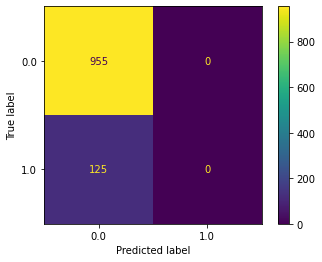

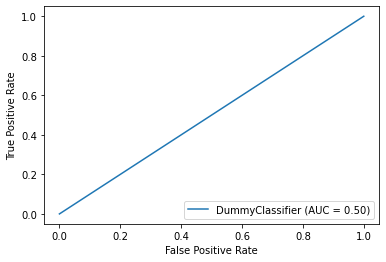

In [26]:
# Instantiate, fit, and run dummy model
dc = DummyClassifier(strategy="most_frequent")
dc.fit(X_train_scaled, y_train)
y_hat_train = dc.predict(X_train_scaled)
y_hat_test = dc.predict(X_test_scaled)
print(f'Train f1_score: {f1_score(y_train, y_hat_train)}')
print(f'Test f1_score: {f1_score(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC for dummy model
plot_confusion_matrix(dc, X_test_scaled, y_test)
plot_roc_curve(dc, X_test_scaled, y_test);

### Model 1: Logistic Regression Model

Train f1_score: 0.0
Test f1_score: 0.0
[[1.04800154 1.06732289 0.99293444 1.12382498 0.98091334 1.10925017
  1.06409937 1.11998739 1.01586097 0.98915247 1.06918142 0.92041704
  0.86600441 1.0046305  0.95192163 1.01535036 1.10060488 1.18879291
  0.98678506 0.99157767 0.93308912 1.01224521 0.98915247 1.12693687
  0.9295423  1.01586097 0.90974497 1.06791222 0.64165443 0.90825786
  1.02472095 0.99180889]]


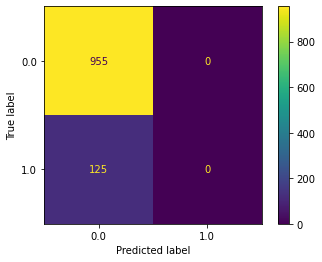

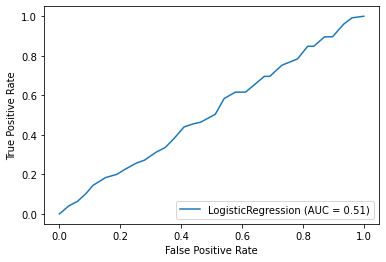

In [27]:
# Instantiate, fit, and run model
lr = LogisticRegression(random_state=22)
lr.fit(X_train_scaled, y_train)
y_hat_train = lr.predict(X_train_scaled)
y_hat_test = lr.predict(X_test_scaled)
print(f'Train f1_score: {f1_score(y_train, y_hat_train)}')
print(f'Test f1_score: {f1_score(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(lr, X_test_scaled, y_test)
plot_roc_curve(lr, X_test_scaled, y_test);

print(np.exp(lr.coef_))

# # Plotted feature importance for basic decision tree model
# ranking = np.exp(lr.coef_)
# fig, ax = plt.subplots(figsize=(20,5))
# pd.Series(ranking).plot.bar(ax=ax);


### Model 2: Random Forest Model

Train f1_score: 0.0
Test f1_score: 0.0


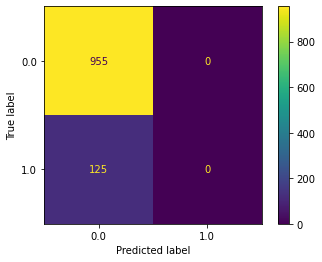

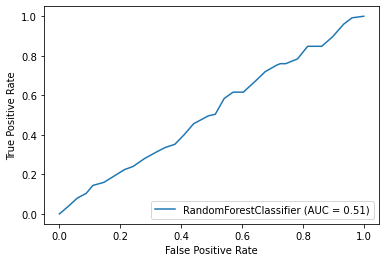

In [28]:
# Instantiate, fit, and run model
rfc = RandomForestClassifier(random_state=22)
rfc.fit(X_train_scaled, y_train)
y_hat_train = rfc.predict(X_train_scaled)
y_hat_test = rfc.predict(X_test_scaled)
print(f'Train f1_score: {f1_score(y_train, y_hat_train)}')
print(f'Test f1_score: {f1_score(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(rfc, X_test_scaled, y_test)
plot_roc_curve(rfc, X_test_scaled, y_test);

### Model 3: XGBoost Model

### Model 4: Naive Bayes Model

### Model 5: Top 3 Ensemble Model

### Pipeline Construction

In [29]:
# # Function with classifier input and pipeline output
# def pipe_maker(classifier):
#     pipe = imbPipeline([('scl', StandardScaler()),('clf', classifier(random_state=22))])
#     return pipe

In [30]:
# # Function with Pipeline & Parameters input and gridsearch with optimum parameters output
# def gridsearch_maker(pipeline, params):
#     f1_scorer = make_scorer(f1_score)
#     return GridSearchCV(estimator=pipeline,
#                         param_grid=params,
#                         scoring=f1_scorer,
#                         cv=5,
#                         n_jobs=-1)

In [31]:
# # Function with pipline/gridsearch input and hyperparameters out for optimized f1_score
# def best_f1(gridsearch):

#     # Instantiate best_f1 object
#     best_f1 = 0.0
    
#     # Fit gridsearch to regularized data set
#     gridsearch.fit(X_train_scaled, y_train)
    
#     # Print best parameters
#     print('Best paramaters are: %s' % gridsearch.best_params_)
    
#     # Print best train f1_score
#     print('Best training f1_score: %.3f' % gridsearch.f1_micro)
    
#     # Prediction on scaled test data
#     y_pred = gridsearch.predict(X_test_scaled)
    
#     # Print test data f1_score with best params
#     print('Test f1_score score with best parameters: %.3f ' % f1_micro(y_test, y_pred))
    
#     # Print confusion matrix and classification report
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
#     print('f1_score score: ', f1_micro(y_test, y_pred))
    
#     # Plot confusion matrix and ROC AUC
#     plot_confusion_matrix(gridsearch, X_test_scaled, y_test,cmap="plasma")
#     plot_roc_curve(dc, X_test_scaled, y_test);

In [32]:
# # Lets try DecisionTreeClassifier and see how that performs.
# pipe_dt = pipe_maker(DummyClassifier)

# # # Creating paramaters
# # grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
# #                    'clf__min_samples_leaf': leaf_range,
# #                    'clf__max_depth': leaf_range,
# #                    'clf__min_samples_split': split_range}]

# # Creating grid search object
# # gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)

# # Finding best parameters for recall score
# best_f1(pipe_dt)